In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from models import Naive
from utils import get_data, train_val_test_split, get_stationary_tvt

YEAR_CUTOFFS = [1953, 1958, 1960]

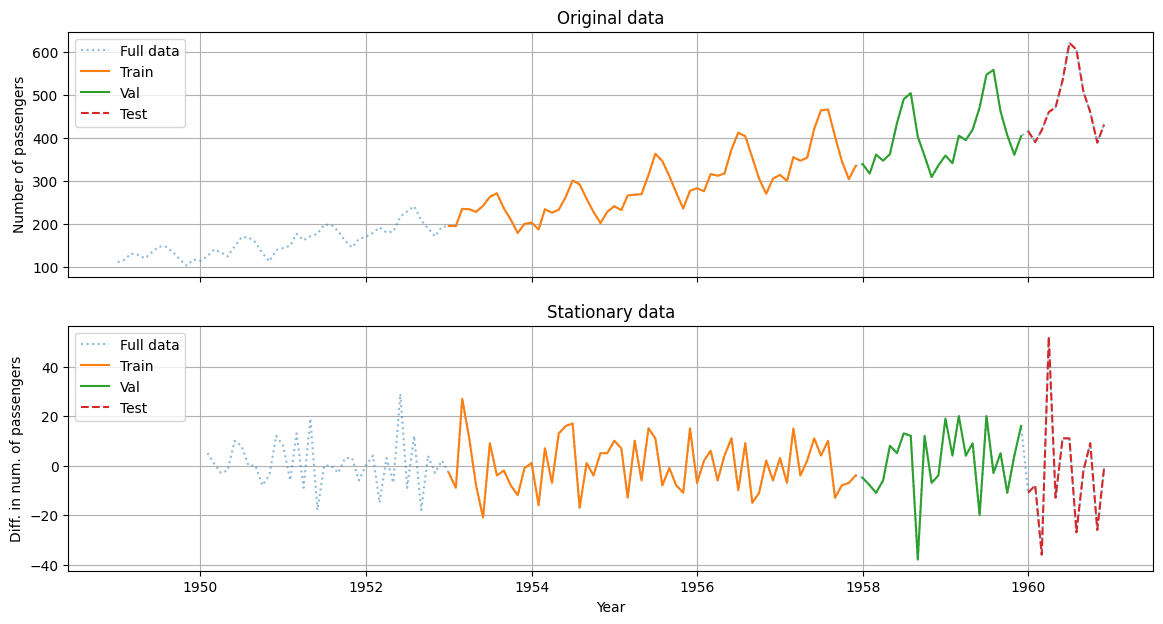

In [ ]:
df = get_data()
train, val, test = train_val_test_split(df, YEAR_CUTOFFS)
train_stationary, val_stationary, test_stationary = get_stationary_tvt(YEAR_CUTOFFS)

fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axs[0].set_title('Original data')

axs[0].set_ylabel('Number of passengers')

axs[0].plot(df, alpha=0.5, linestyle='dotted', label='Full data')
axs[0].plot(train, label='Train')
axs[0].plot(val, label='Val')
axs[0].plot(test, linestyle='dashed', label='Test')

axs[0].grid()
axs[0].legend()

axs[1].set_title('Stationary data')

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Diff. in num. of passengers')

axs[1].plot(df_stationary, alpha=0.5, linestyle='dotted', label='Full data')
axs[1].plot(train_stationary, label='Train')
axs[1].plot(val_stationary, label='Val')
axs[1].plot(test_stationary, linestyle='dashed', label='Test')

axs[1].grid()
axs[1].legend()

plt.show()

In [17]:
models = {
    'Naive': {
        'model': Naive(),
        'stationary': False,
    },
}

In [18]:
for model_name in models:
    model_dict = models[model_name]
    model = model_dict['model']
    if model_dict['stationary']:
        model.train(train_stationary)
        pred_stationary = model.predict(val_stationary)
        model_dict['pred_stationary'] = pred_stationary
        model_dict['rmse_stationary'] = np.sqrt(mean_squared_error(val_stationary, pred_stationary))
    else:
        model.train(train)
        pred = model.predict(val)
        model_dict['pred_stationary'] = None
        model_dict['rmse_stationary'] = None
        model_dict['pred'] = pred
        model_dict['rmse'] = np.sqrt(mean_squared_error(val, pred))

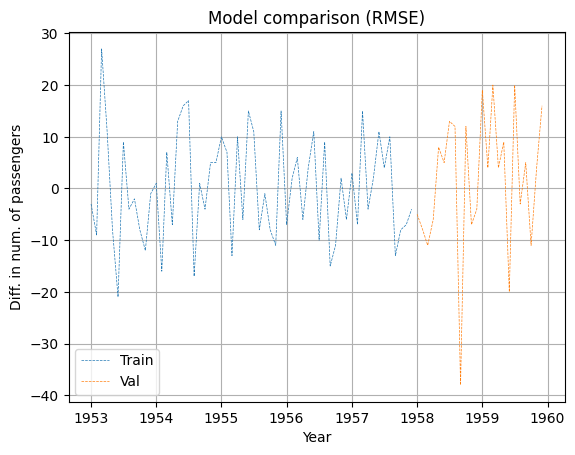

In [19]:
plt.title('Model comparison (RMSE)')

plt.xlabel('Year')
plt.ylabel('Diff. in num. of passengers')

plt.plot(train_stationary, linewidth=0.5, linestyle='dashed', label='Train')
plt.plot(val_stationary, linewidth=0.5, linestyle='dashed', label='Val')

for model_name in models:
    if models[model_name]['stationary']:
        pred_stationary = models[model_name]['pred_stationary']
        rmse_stationary = models[model_name]['rmse_stationary']
        plt.plot(pred_stationary, label=f'{model_name} model ({rmse_stationary:.2f})')

plt.grid()
plt.legend()
plt.show()

In [20]:
df_diff_1 = df.copy()
df_diff_1['#Passengers'] = df_diff_1['#Passengers'].diff(1)
train_diff_1, val_diff_1, test_diff_1 = train_val_test_split(df_diff_1, YEAR_CUTOFFS)

for model_name in models:
    if models[model_name]['stationary']:

        pred_stationary = models[model_name]['pred_stationary']

        # Revert .diff(12)

        avg_12 = (
            train_diff_1['#Passengers'][-60:-48].values +
            train_diff_1['#Passengers'][-48:-36].values +
            train_diff_1['#Passengers'][-36:-24].values +
            train_diff_1['#Passengers'][-24:-12].values +
            train_diff_1['#Passengers'][-12:].values
        ) / 5
        avg_12 = pd.Series(avg_12, train_diff_1[-12:].index)

        pred = pd.concat([avg_12, pred_stationary])

        for i in range(12, len(pred)):
            pred[i] += pred[i - 12]

        # Revert .diff(1)

        pred = pd.concat([train['#Passengers'][-1:], pred[12:]])

        for i in range(1, len(pred)):
            pred[i] += pred[i - 1]

        pred = pred[1:]

        # Save

        models[model_name]['pred'] = pred
        models[model_name]['rmse'] = np.sqrt(mean_squared_error(val, pred))

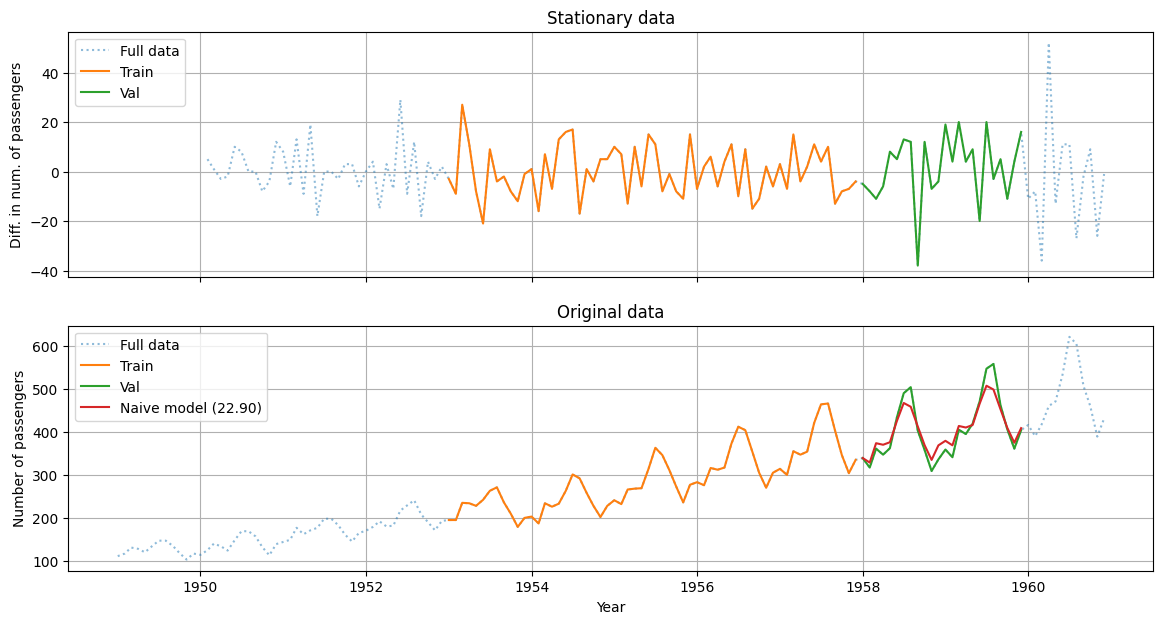

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axs[0].set_title('Stationary data')

axs[0].set_ylabel('Diff. in num. of passengers')

axs[0].plot(df_stationary, alpha=0.5, linestyle='dotted', label='Full data')
axs[0].plot(train_stationary, label='Train')
axs[0].plot(val_stationary, label='Val')

for model_name in models:
    if models[model_name]['stationary']:
        pred_stationary = models[model_name]['pred_stationary']
        rmse_stationary = models[model_name]['rmse_stationary']
        axs[0].plot(pred_stationary, label=f'{model_name} model ({rmse_stationary:.2f})')

axs[0].grid()
axs[0].legend(loc='upper left')

axs[1].set_title('Original data')

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of passengers')

axs[1].plot(df, alpha=0.5, linestyle='dotted', label='Full data')
axs[1].plot(train, label='Train')
axs[1].plot(val, label='Val')

for model_name in models:
    pred = models[model_name]['pred']
    rmse = models[model_name]['rmse']
    axs[1].plot(pred, label=f'{model_name} model ({rmse:.2f})')

axs[1].grid()
axs[1].legend()

plt.show()